# Titanic DataSet 

# Training

*Steps*:

1. Randomly initialize the model's weights $W$.
2. Feed inputs $X$ into the model to receive the logits ($z=XW$). Apply the softmax operation on the logits to get the class probabilies $\hat{y}$ in one-hot encoded form. For example, if there are three classes, the predicted class probabilities could look like [0.3, 0.3, 0.4]. 
3. Compare the predictions $\hat{y}$ (ex.  [0.3, 0.3, 0.4]]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for logistics regression is cross-entropy loss. 
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) =  - \sum_i y_i ln (\frac{e^{X_iW_y}}{\sum e^{X_iW}}) $
   * $y$ = [0, 0, 1]
  * $\hat{y}$ = [0.3, 0.3, 0.4]]
  * $J(\theta) = - \sum_i y_i ln (\hat{y_i}) =  - \sum_i y_i ln (\frac{e^{X_iW_y}}{\sum e^{X_iW}}) = - \sum_i [0 * ln(0.3) + 0 * ln(0.3) + 1 * ln(0.4)] = -ln(0.4) $
  * This simplifies our cross entropy objective to the following: $J(\theta) = - ln(\hat{y_i})$ (negative log likelihood).
  * $J(\theta) = - ln(\hat{y_i}) = - ln (\frac{e^{X_iW_y}}{\sum_i e^{X_iW}}) $
4. Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights. Let's assume that our classes are mutually exclusive (a set of inputs could only belong to one class).
 * $\frac{\partial{J}}{\partial{W_j}} = \frac{\partial{J}}{\partial{y}}\frac{\partial{y}}{\partial{W_j}} = - \frac{1}{y}\frac{\partial{y}}{\partial{W_j}} = - \frac{1}{\frac{e^{W_yX}}{\sum e^{XW}}}\frac{\sum e^{XW}e^{W_yX}0 - e^{W_yX}e^{W_jX}X}{(\sum e^{XW})^2} = \frac{Xe^{W_j}X}{\sum e^{XW}} = XP$
  * $\frac{\partial{J}}{\partial{W_y}} = \frac{\partial{J}}{\partial{y}}\frac{\partial{y}}{\partial{W_y}} = - \frac{1}{y}\frac{\partial{y}}{\partial{W_y}} = - \frac{1}{\frac{e^{W_yX}}{\sum e^{XW}}}\frac{\sum e^{XW}e^{W_yX}X - e^{W_yX}e^{W_yX}X}{(\sum e^{XW})^2} = \frac{1}{P}(XP - XP^2) = X(P-1)$
5. Apply backpropagation to update the weights $W$ using gradient descent. The updates will penalize the probabiltiy for the incorrect classes (j) and encourage a higher probability for the correct class (y).
  * $W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}$
6. Repeat steps 2 - 4 until model performs well.

# Data

We're going to the load the titanic dataset

In [1]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib

In [2]:
# Arguments
args = Namespace(
    seed=1234,
    data_file="titanic_original.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
    max_depth=4,
    min_samples_leaf=5,
    n_estimators=10, # of trees in the forest
)
# Set seed for reproducability
np.random.seed(args.seed)


In [3]:
# Read from CSV to Pandas DataFrame
df = pd.read_csv(args.data_file, header=0)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
#Replacing empty spaces with Null values
df = df.replace(r'^\s+$', np.nan, regex=True)

# Exploratory Data Analysis

In [5]:
# Check for Null Values
df.apply(lambda x: sum(x.isnull()), axis=0)

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [6]:
#removing cabin , body ,boat , home.dest since they are more than 50 % nan
df = df.drop(["cabin","home.dest","boat","body"],axis = 1)
df.apply(lambda x: sum(x.isnull()), axis=0)

pclass        0
survived      0
name          0
sex           0
age         263
sibsp         0
parch         0
ticket        0
fare          1
embarked      2
dtype: int64

In [7]:
all_columns_list = df.columns.tolist()
categorical_columns_list = ['pclass', 'survived','sex','embarked']
character_columns_list = ['name', 'ticket']
char_cat = character_columns_list ; char_cat.extend(categorical_columns_list)
numerical_columns_list = [e for e in all_columns_list if e not in char_cat]
for index in categorical_columns_list:
    df[index] = pd.Categorical(df[index])
for index in numerical_columns_list:
    df[index] = pd.to_numeric(df[index])
for index in character_columns_list:
    df[index] = df[index].astype(str)

In [8]:
import numpy as np
df['age'] = df['age'].fillna(np.nanmedian(df.age)).astype(int)
df['age'] = df['age'].astype(int)
df['fare'] = df['fare'].fillna(np.nanmedian(df.age)).astype(int)


In [9]:
df.embarked

0       S
1       S
2       S
3       S
4       S
5       S
6       S
7       S
8       S
9       C
10      C
11      C
12      C
13      S
14      S
15      S
16      C
17      C
18      C
19      C
20      S
21      S
22      C
23      C
24      S
25      C
26      C
27      C
28      S
29      S
       ..
1279    S
1280    S
1281    S
1282    S
1283    S
1284    S
1285    S
1286    C
1287    S
1288    S
1289    S
1290    S
1291    S
1292    S
1293    S
1294    S
1295    S
1296    S
1297    S
1298    S
1299    C
1300    C
1301    C
1302    C
1303    C
1304    C
1305    C
1306    C
1307    C
1308    S
Name: embarked, Length: 1309, dtype: object

In [10]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
pclass      1309 non-null object
survived    1309 non-null object
name        1309 non-null object
sex         1309 non-null object
age         1309 non-null int64
sibsp       1309 non-null int64
parch       1309 non-null int64
ticket      1309 non-null object
fare        1309 non-null int64
embarked    1309 non-null object
dtypes: int64(4), object(6)
memory usage: 102.3+ KB


In [11]:
num = ['float64', 'int64']
num_df = df.select_dtypes(include=num)
obj_df = df.select_dtypes(exclude=num)

In [12]:
obj_df.describe().T

,count,unique,top,freq
pclass,1309,3,3,709
survived,1309,2,0,809
name,1309,1307,"Connolly, Miss. Kate",2
sex,1309,2,male,843
ticket,1309,929,CA. 2343,11
embarked,1309,4,S,914


In [13]:
num_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1309.0,29.484339,12.916721,0.0,22.0,28.0,35.0,80.0
sibsp,1309.0,0.498854,1.041658,0.0,0.0,0.0,1.0,8.0
parch,1309.0,0.385027,0.865560,0.0,0.0,0.0,0.0,9.0
fare,1309.0,32.865546,51.747419,0.0,7.0,14.0,31.0,512.0


In [14]:
print(df.groupby('survived').size())
print(df['survived'].value_counts(normalize = True) * 100)
df1 = df

survived
0    809
1    500
dtype: int64
0    61.802903
1    38.197097
Name: survived, dtype: float64


In [15]:
import seaborn as sns

## Univariate Distribution

[(0, 100)]

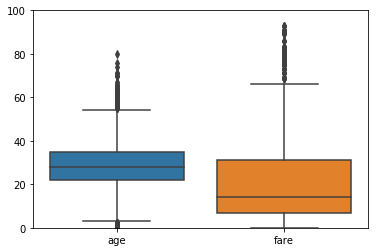

In [16]:
sns.boxplot(data = num_df[['age','fare']]).set(ylim=(0, 100))

[(0, 4)]

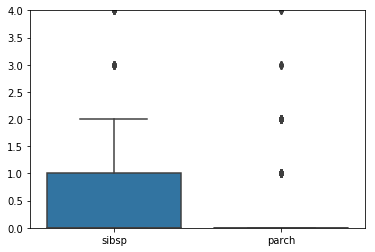

In [17]:
sns.boxplot(data = num_df[['sibsp','parch']]).set(ylim=(0, 4))

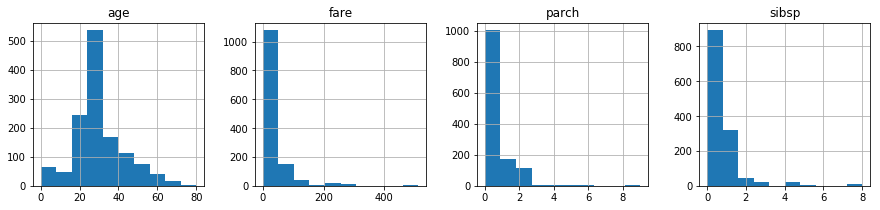

In [18]:
# histogram plots
num_df.hist(layout=(1,4), figsize=(15,3))
plt.plot();

In [19]:
num_df = pd.concat([num_df,df["survived"]],axis=1)

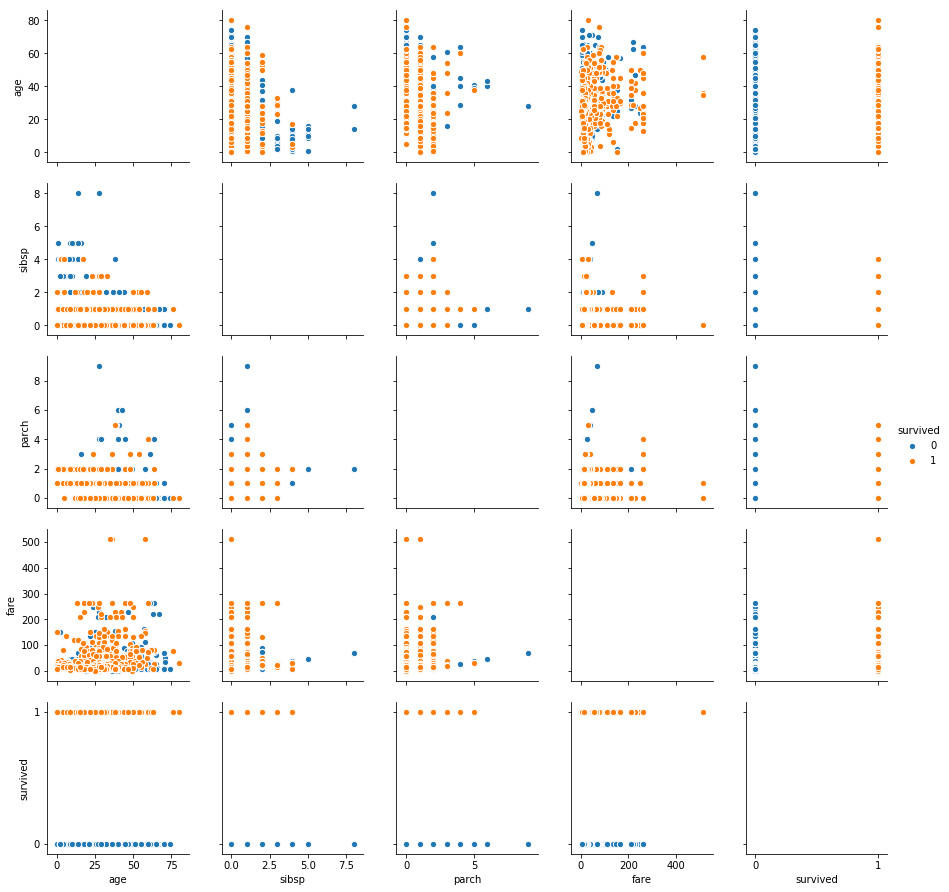

In [20]:
#Plotting pair plot to identify relationship between 'survived' and other variables
g = sns.PairGrid(num_df, hue='survived')
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend()

## Bivariate Distribution

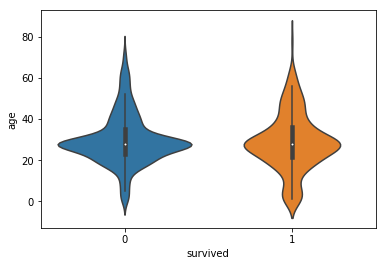

In [21]:
sns.violinplot(x="survived", y="age", data=num_df);

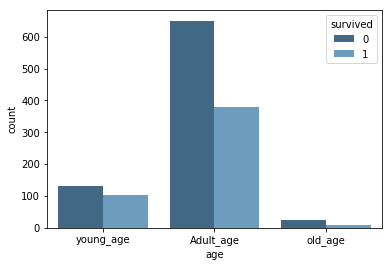

In [22]:
Age_bins=pd.cut(num_df["age"], bins=[0,20,60,80], labels=['young_age','Adult_age','old_age'])
sns.countplot(x=Age_bins, hue="survived", data=num_df, palette="Blues_d");

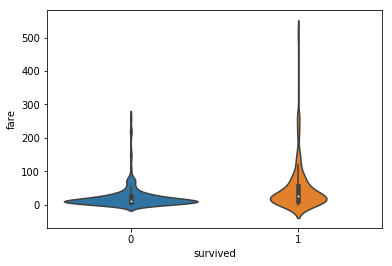

In [23]:
sns.violinplot(x="survived", y="fare", data=num_df);

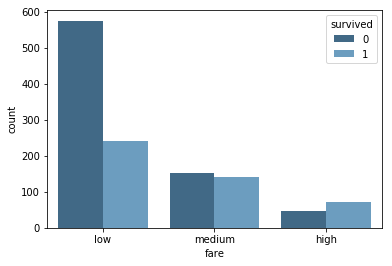

In [24]:
#Creating bins and plotting Countplot for 'MonthlyCharges'
fare_bins=pd.cut(num_df["fare"], bins=[0,25,60,130], labels=['low','medium','high'])
sns.countplot(x=fare_bins, hue="survived", data=num_df, palette="Blues_d");

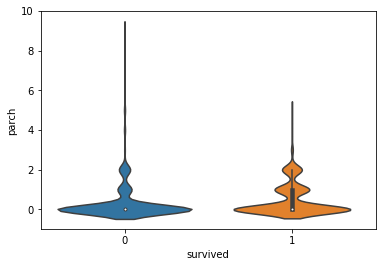

In [25]:
sns.violinplot(x="survived", y="parch", data=num_df);

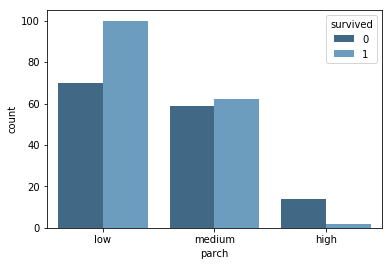

In [26]:
#Creating bins and plotting Countplot for 'MonthlyCharges'
parch_bins=pd.cut(num_df["parch"], bins=[0,1,3,15], labels=['low','medium','high'])
sns.countplot(x=parch_bins, hue="survived", data=num_df, palette="Blues_d");

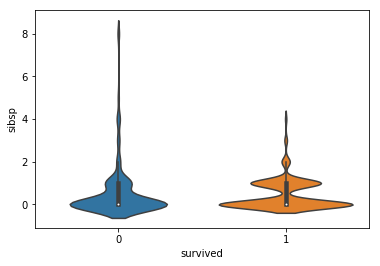

In [27]:
sns.violinplot(x="survived", y="sibsp", data=num_df);

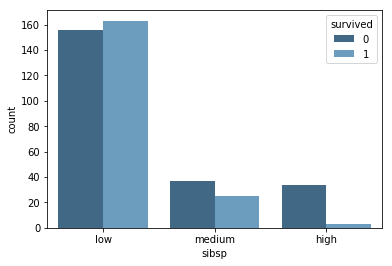

In [28]:
#Creating bins and plotting Countplot for 'MonthlyCharges'
sibsp_bins=pd.cut(num_df["sibsp"], bins=[0,1,3,15], labels=['low','medium','high'])
sns.countplot(x=sibsp_bins, hue="survived", data=num_df, palette="Blues_d");

## Numerical vs Categorical Variables

/home/harsh/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


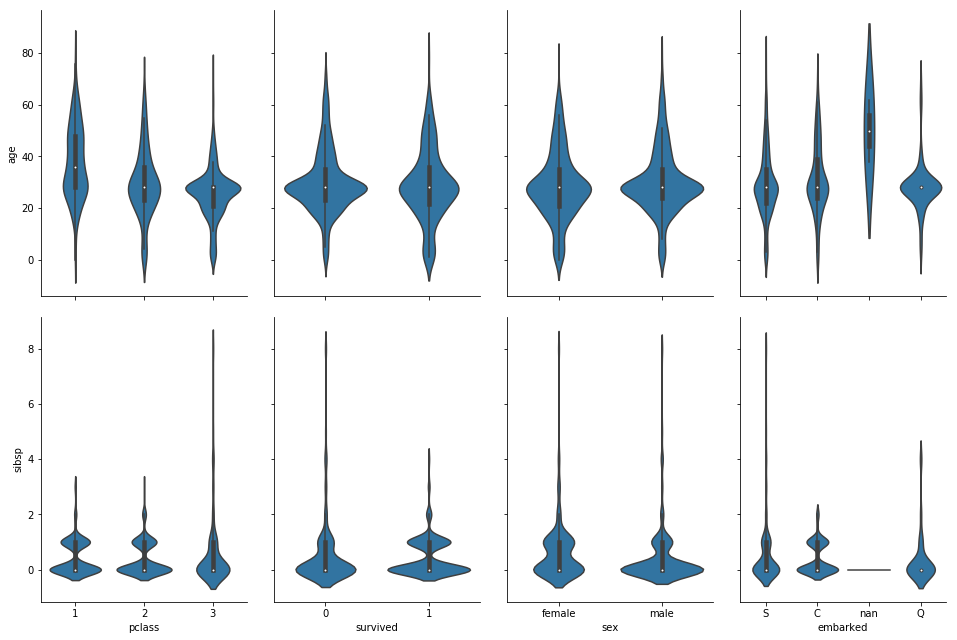

In [29]:
# Splitting the third set and plotting against numeric variables
g = sns.PairGrid(df, x_vars=obj_df.columns[[0,1,3,5]].values,
    y_vars=num_df.columns[0:2].values, aspect=.75, size=4.5)
g.map(sns.violinplot);

## Categorical Variables

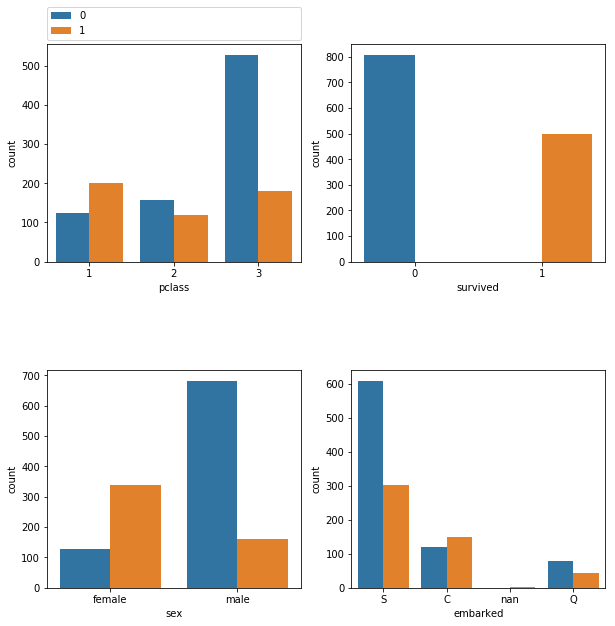

In [30]:
fig,ax =plt.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=.5)
m=0
for i in [0,1,3,5]:
    g = sns.countplot(x=obj_df.iloc[:,i], hue=obj_df["survived"], ax=ax[divmod(m,2)])
    m+=1
    g.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0.) if i==0 else g.legend_.remove()

# Scikit-learn implementation - Logistic Regression

**Note**: The `LogisticRegression` class in Scikit-learn uses coordinate descent to solve the fit. However, we are going to use Scikit-learn's `SGDClassifier` class which uses stochastic gradient descent. We want to use this optimization approach because we will be using this for the models in subsequent lessons.

In [31]:
# Import packages
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [32]:
# Preprocessing
def preprocess(df):
  
    # Drop rows with NaN values
    df = df.dropna()

    # Drop text based features 
    features_to_drop = ["name", "ticket"]
    df = df.drop(features_to_drop, axis=1)

    # pclass, sex, and embarked are categorical features
    categorical_features = ["pclass","embarked","sex"]
    df = pd.get_dummies(df, columns=categorical_features)

    return df

In [33]:
# Preprocess the dataset
df = preprocess(df)
df.head()

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,embarked_nan,sex_female,sex_male
0,1,29,0,0,211,1,0,0,0,0,1,0,1,0
1,1,0,1,2,151,1,0,0,0,0,1,0,0,1
2,0,2,1,2,151,1,0,0,0,0,1,0,1,0
3,0,30,1,2,151,1,0,0,0,0,1,0,0,1
4,0,25,1,2,151,1,0,0,0,0,1,0,1,0


In [34]:
# Split the data
mask = np.random.rand(len(df)) < args.train_size
train_df = df[mask]
test_df = df[~mask]
print ("Train size: {0}, test size: {1}".format(len(train_df), len(test_df)))

Train size: 968, test size: 341


In [35]:
# Separate X and y
X_train = train_df.drop(["survived"], axis=1)
y_train = train_df["survived"]
X_test = test_df.drop(["survived"], axis=1)
y_test = test_df["survived"]

In [36]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

# Apply scaler on training and test data (don't standardize outputs for classification)
standardized_X_train = X_scaler.transform(X_train)
standardized_X_test = X_scaler.transform(X_test)

# Check
print ("mean:", np.mean(standardized_X_train, axis=0)) # mean should be ~0
print ("std:", np.std(standardized_X_train, axis=0))   # std should be 1

mean: [ 1.17445080e-16 -8.07434927e-17  4.40419051e-17  2.93612701e-17
  1.17445080e-16  1.76167620e-16 -2.34890161e-16 -1.17445080e-16
  7.34031752e-17  7.52382546e-17  0.00000000e+00 -7.34031752e-18
  7.34031752e-18]
std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/home/harsh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/harsh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """
/home/harsh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [37]:
# Initialize the model
log_reg = SGDClassifier(loss="log", penalty="none", max_iter=args.num_epochs, 
                        random_state=args.seed)

In [38]:
# Train
log_reg.fit(X=standardized_X_train, y=y_train)

/home/harsh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
# Probabilities
pred_test = log_reg.predict_proba(standardized_X_test)
print (pred_test[:5])

[[0.61679417 0.38320583]
 [0.04341551 0.95658449]
 [0.73245719 0.26754281]
 [0.25489022 0.74510978]
 [0.50792505 0.49207495]]


In [40]:
# Predictions (unstandardize them)
pred_train = log_reg.predict(standardized_X_train) 
pred_test = log_reg.predict(standardized_X_test)
print (pred_test)

['0' '1' '0' '1' '0' '1' '1' '1' '1' '0' '1' '0' '1' '1' '0' '1' '0' '1'
 '1' '0' '1' '0' '0' '1' '0' '1' '1' '0' '1' '0' '0' '1' '1' '1' '1' '1'
 '1' '0' '0' '1' '0' '0' '0' '1' '1' '0' '1' '1' '1' '0' '1' '1' '1' '1'
 '1' '0' '1' '0' '1' '1' '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '0' '1'
 '1' '1' '1' '0' '1' '1' '0' '1' '1' '0' '0' '1' '0' '1' '0' '0' '1' '1'
 '1' '1' '0' '0' '0' '0' '1' '0' '0' '0' '1' '0' '0' '1' '0' '0' '1' '0'
 '0' '1' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '0' '0' '1'
 '0' '0' '1' '0' '1' '1' '0' '0' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0'
 '0' '0' '0' '0' '1' '0' '0' '1' '1' '1' '0' '0' '1' '0' '1' '1' '0' '0'
 '1' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '0' '0' '0'
 '0' '0' '1' '0' '0' '0' '1' '0' '0' '0' '1' '0' '1' '0' '0' '0' '1' '0'
 '1' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '0' '1' '0' '1' '0' '1' '0'
 '0' '0' '0' '0' '0' '1' '1' '1' '0' '0' '1' '0' '0

# Evaluation metrics

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.78, test acc: 0.79


In [43]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       201
           1       0.77      0.71      0.74       140

   micro avg       0.79      0.79      0.79       341
   macro avg       0.79      0.78      0.78       341
weighted avg       0.79      0.79      0.79       341



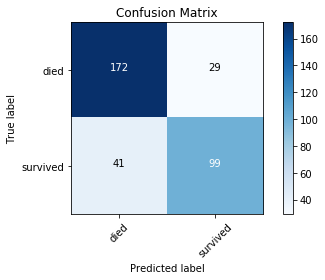

In [45]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=["died", "survived"])

print (classification_report(y_test, pred_test))

# Inference

Now let's see if I would've survived the titanic.

In [46]:
# Input your information
X_infer = pd.DataFrame([{"name": "Harsh Maheshwari", "cabin": "E", "ticket": "E44", 
                         "pclass": 1, "age": 19, "sibsp": 1, "parch": 2, 
                         "fare": 100, "embarked": "C", "sex": "male"}])
X_infer.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,ticket
0,19,E,C,100,Harsh Maheshwari,2,1,male,1,E44


In [47]:
# Apply preprocessing
X_infer = preprocess(X_infer)
X_infer.head()

,age,cabin,fare,parch,sibsp,pclass_1,embarked_C,sex_male
0,19,E,100,2,1,1,1,1


In [48]:
# Add missing columns
missing_features = set(X_test.columns) - set(X_infer.columns)
for feature in missing_features:
    X_infer[feature] = 0

# Reorganize header
X_infer = X_infer[X_train.columns]
X_infer.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,embarked_nan,sex_female,sex_male
0,19,1,2,100,1,0,0,1,0,0,0,0,1


In [49]:
# Standardize
standardized_X_infer = X_scaler.transform(X_infer)

/home/harsh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [50]:
# Predict
y_infer = log_reg.predict_proba(standardized_X_infer)
classes = {0: "died", 1: "survived"}
_class = np.argmax(y_infer)
print ("Looks like I would've {0} with about {1:.0f}% probability on the Titanic expedition!".format(
    classes[_class], y_infer[0][_class]*100.0))

Looks like I would've survived with about 59% probability on the Titanic expedition!


# Interpretability

Which of the features are most influential?

In [51]:
# Unstandardize coefficients 
coef = log_reg.coef_ / X_scaler.scale_
intercept = log_reg.intercept_ - np.sum((coef * X_scaler.mean_))
print (coef)
print (intercept)

[[-1.67684563e-02 -8.08089274e-01 -6.62169514e-02  8.74681629e-03
   8.18880945e-01  6.85440485e-02 -6.61256434e-01  5.20786495e-01
  -2.19949512e-02 -5.62632574e-01  3.36790856e+01  1.74233662e+00
  -1.74233662e+00]]
[1.13293273]


A positive coefficient signifies correlation with the positive class (1=survived) and a negative coefficient signifies correlation with the negative class (0=died).

In [52]:
indices = np.argsort(coef)
features = list(X_train.columns)
print ("Features correlated with death:", [features[i] for i in indices[0][:3]])
print ("Features correlated with survival:", [features[i] for i in indices[0][-3:]])

Features correlated with death: ['sex_male', 'sibsp', 'pclass_3']
Features correlated with survival: ['pclass_1', 'sex_female', 'embarked_nan']


### Proof for unstandardizing coefficients:



Note that only X was standardized.

$\mathbb{E}[y] = W_0 + \sum_{j=1}^{k}W_jz_j$

$z_j = \frac{x_j - \bar{x}_j}{\sigma_j}$

$ \hat{y} = \hat{W_0} + \sum_{j=1}^{k}\hat{W_j}z_j $

$\hat{y} = \hat{W_0} + \sum_{j=1}^{k} \hat{W}_j (\frac{x_j - \bar{x}_j}{\sigma_j}) $

$\hat{y} = (\hat{W_0} - \sum_{j=1}^{k} \hat{W}_j\frac{\bar{x}_j}{\sigma_j}) +  \sum_{j=1}^{k} (\frac{\hat{w}_j}{\sigma_j})x_j$

# Scikit-learn implementation - Decision Tree

In [53]:
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Preprocessing
def preprocess(df):
  
    # Drop rows with NaN values
    df = df.dropna()

    # Drop text based features (we'll learn how to use them in later lessons)
    features_to_drop = ["name", "ticket"]
    df = df.drop(features_to_drop, axis=1)

    # pclass, sex, and embarked are categorical features
    # We need to convert strings to floats for decision trees instead of
    # using dummy variables.
    df['sex'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)
    df["embarked"] = df['embarked'].dropna()
    df["embarked"] = df['embarked'].map( {'S':0, 'C':1, 'Q':2, 'nan':1 } ).astype(int)
    return df

In [55]:
# Preprocess the dataset
df = preprocess(df1)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,0,29,0,0,211,0
1,1,1,1,0,1,2,151,0
2,1,0,0,2,1,2,151,0
3,1,0,1,30,1,2,151,0
4,1,0,0,25,1,2,151,0


In [56]:
# Split the data
mask = np.random.rand(len(df)) < args.train_size
train_df = df[mask]
test_df = df[~mask]
print ("Train size: {0}, test size: {1}".format(len(train_df), len(test_df)))

Train size: 982, test size: 327


In [57]:
# Separate X and y
X_train = train_df.drop(["survived"], axis=1)
y_train = train_df["survived"]
X_test = test_df.drop(["survived"], axis=1)
y_test = test_df["survived"]

In [58]:
# Initialize the model
dtree = DecisionTreeClassifier(criterion="entropy", random_state=args.seed, 
                               max_depth=args.max_depth, 
                               min_samples_leaf=args.min_samples_leaf)

In [59]:
# Training
dtree.fit(X_train, y_train)
# Predictions
pred_train = dtree.predict(X_train)
pred_test = dtree.predict(X_test)

# Evaluation

In [60]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [61]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.82, test acc: 0.80


# Interpretability

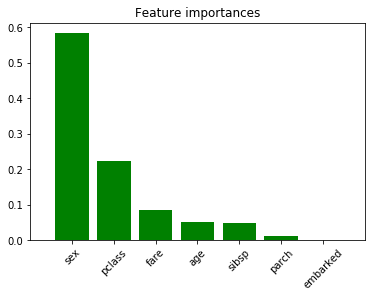

sex - 0.584
pclass - 0.224
fare - 0.084
age - 0.050
sibsp - 0.048
parch - 0.010
embarked - 0.000


In [63]:
# Feature importances
features = list(X_test.columns)
importances = dtree.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# Print values
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# Random forests

A group, or ensemble, of decision trees together create a random forest. The idea is that a group of different trees will yield more accurate predictions compared to a single decision tree. But how can we have different trees if they're all made using the same data and optimized on a metric like IG? The trick here is that the different decision trees in the random forest are made of different subsets of data and even different thresholds for features. 

# Scikit-learn implementation - Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
# Initialize Random forest
forest = RandomForestClassifier(
    n_estimators=args.n_estimators, criterion="entropy", 
    max_depth=args.max_depth, min_samples_leaf=args.min_samples_leaf)

In [66]:
# Train
forest.fit(X_train, y_train)
# Predictions
pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)

In [67]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.82, test acc: 0.77


# Interpretability

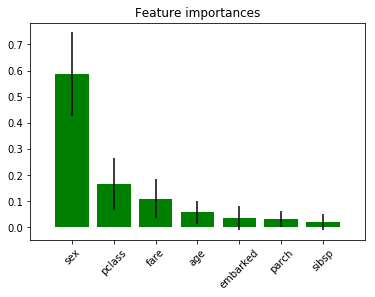

sex - 0.585
pclass - 0.165
fare - 0.109
age - 0.056
embarked - 0.034
parch - 0.030
sibsp - 0.020


In [68]:
# Feature importances
features = list(X_test.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], 
        color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# Print values
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# Grid Search
In our random forest, we have many different hyperparameters (criterion, max_depth, etc.) and many of the models we will see in future lessons will have even more parameters. How will we know what values to pick? We have to tune the values based on the performance they yield on the validation set. Scikit learn offers functions to do exhastive grid search so that we can tune our hyperparamters. 

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [len(features)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8],
    'n_estimators': [5, 10, 50] # of trees
}

In [71]:
# Initialize random forest
forest = RandomForestClassifier()
# Instantiate grid search
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
# Fit grid search to the data
grid_search.fit(X_train, y_train)
# See the best combination of parameters
grid_search.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    8.7s finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 7,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 5}

In [72]:
# Train using best parameters
best_forest = grid_search.best_estimator_
best_forest.fit(X_train, y_train)
# Predictions
pred_train = best_forest.predict(X_train)
pred_test = best_forest.predict(X_test)

In [73]:
# Accuracy
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print ("train acc: {0:.2f}, test acc: {1:.2f}".format(train_acc, test_acc))

train acc: 0.86, test acc: 0.83
